In [2]:
directory  = 'Downloads\land_dataset\land\data'

In [6]:
class_name = ["cloudy","desert","green_area","water"]

In [3]:
#Importing the libraries
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,BatchNormalization,GlobalAveragePooling2D,InputLayer,Input,Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import CategoricalAccuracy,TopKCategoricalAccuracy
from tensorflow.keras.regularizers import L1,L2

In [29]:
#loading the dataset
dataset =tf.keras.utils.image_dataset_from_directory(
    directory  = 'Downloads\land_dataset\land\data',
    labels='inferred',
    label_mode='categorical',
    class_names = ["cloudy","desert","green_area","water"],
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=99
)

Found 5631 files belonging to 4 classes.


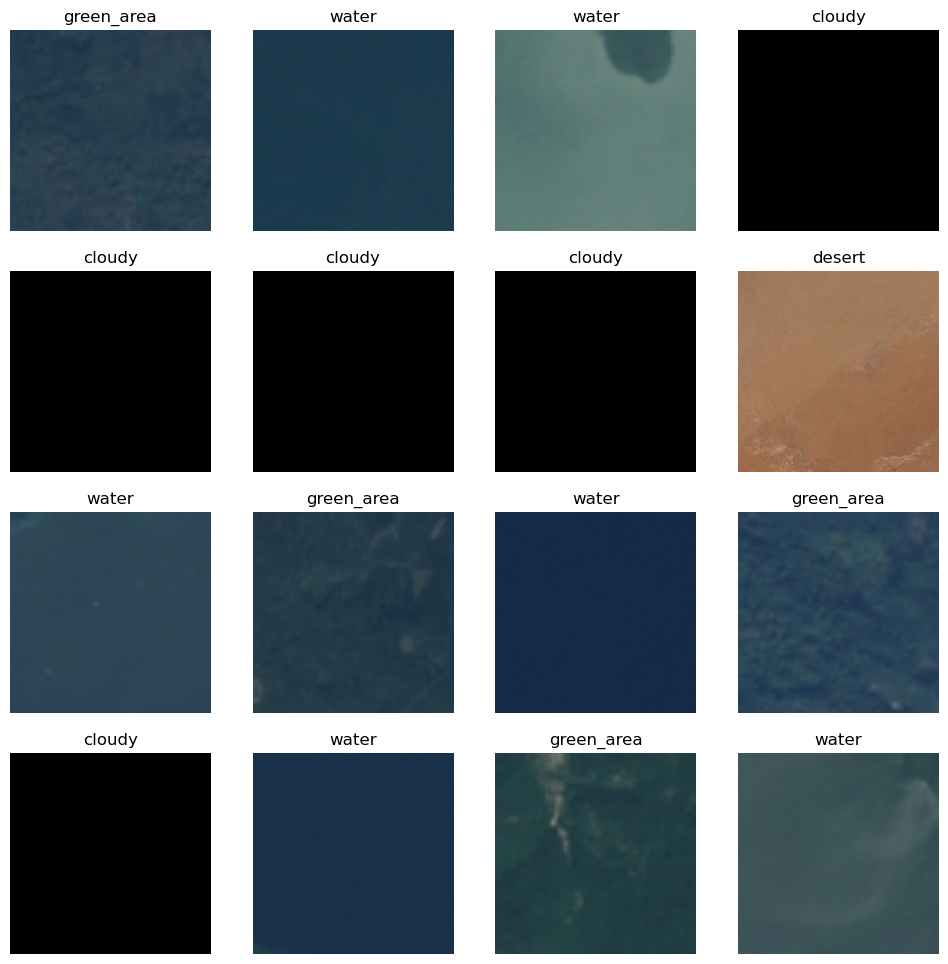

In [30]:
plt.figure(figsize = (12,12))

for images, labels in dataset.take(1):
    for i in range(16): # Loop through a subset of images in the batch (in this case, 16 images)
        ax = plt.subplot(4,4, i+1)
        plt.imshow(images[i]/255.)
        plt.title(class_name[tf.argmax(labels[i],axis=0).numpy()])
        plt.axis("off")

In [31]:
# Create a training dataset by taking 80% of the samples from the original dataset 
train_dataset = dataset.take(int(0.80*len(dataset)))

In [32]:
# Create a combined validation and test dataset by skipping the first 80% of the samples from the original dataset
val_test_dataset = dataset.skip(int(0.80*len(dataset)))

# Create a validation dataset by taking 10% of the remaining samples from the combined validation and test dataset
val_dataset = val_test_dataset.take(int(0.10*len(dataset)))

# Create a test dataset by skipping the first 10% of the validation dataset
test_dataset = val_dataset.skip(int(0.10*len(dataset)))

In [62]:
test_dataset = val_test_dataset.take(int(0.10*len(dataset)))

In [33]:
# Normalize the dataset
def process(image, label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train_dataset = train_dataset.map(process)
val_dataset = val_dataset.map(process)
test_dataset = test_dataset.map(process)

In [34]:
# Define the list of metrics
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

## VGGNet Model

In [79]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D

# Define the model architecture based on VGGNet
model_VggNet = Sequential()

model_VggNet.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_VggNet.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_VggNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model_VggNet.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_VggNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model_VggNet.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_VggNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model_VggNet.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model_VggNet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

In [80]:
model_VggNet.add(Flatten())
model_VggNet.add(Dense(units=1024, activation="relu"))
model_VggNet.add(Dense(units=256, activation="relu"))
model_VggNet.add(Dense(units=4, activation="softmax"))

In [81]:
model_VggNet.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_18 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 112, 112, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 56, 56, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 56, 56, 256)      

In [82]:
model_VggNet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=metrics)

In [83]:
history = model_VggNet.fit(train_dataset,epochs=3,validation_data=val_dataset,verbose=1)

Epoch 1/3
140/140 [==============================] - 1198s 9s/step - loss: 0.4834 - accuracy: 0.7128 - top_k_accuracy: 0.9763 - val_loss: 0.2766 - val_accuracy: 0.8419 - val_top_k_accuracy: 1.0000
Epoch 2/3
140/140 [==============================] - 1192s 9s/step - loss: 0.2898 - accuracy: 0.8511 - top_k_accuracy: 1.0000 - val_loss: 0.2471 - val_accuracy: 0.8842 - val_top_k_accuracy: 1.0000
Epoch 3/3
140/140 [==============================] - 1174s 8s/step - loss: 0.3366 - accuracy: 0.8817 - top_k_accuracy: 0.9962 - val_loss: 0.1512 - val_accuracy: 0.9504 - val_top_k_accuracy: 1.0000


In [84]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_top_k_accuracy = model_VggNet.evaluate(test_dataset)

# Print the final metrics
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Top-K Accuracy (K=2): {test_top_k_accuracy}')

17/17 [==============================] - 38s 2s/step - loss: 640.6592 - accuracy: 0.4890 - top_k_accuracy: 1.0000
Test Loss: 640.6592407226562
Test Accuracy: 0.4889705777168274
Test Top-K Accuracy (K=2): 1.0


In [85]:
from tensorflow.keras.models import save_model
model_path = 'model_VggNet.h5'
# Save the model
save_model(model_VggNet, model_path)

C:\Users\Dell\AppData\Local\Temp\ipykernel_10740\1612576138.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_VggNet, model_path)


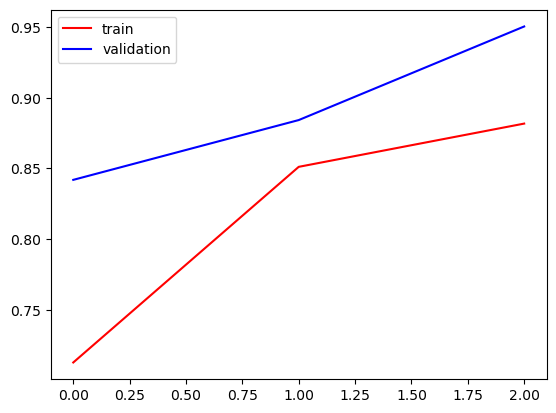

In [86]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

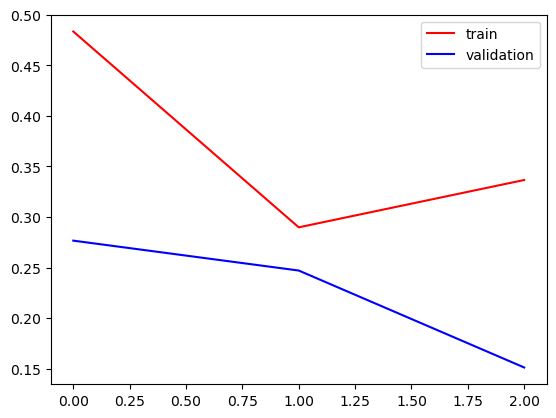

In [87]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## ResNet Model

In [45]:
model_resnet = Sequential()

# Define the model architecture based on ResNet
model_resnet.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_resnet.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_resnet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_resnet.add(BatchNormalization())

model_resnet.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_resnet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_resnet.add(BatchNormalization())

model_resnet.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model_resnet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_resnet.add(BatchNormalization())

model_resnet.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model_resnet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_resnet.add(BatchNormalization())

model_resnet.add(Flatten())
model_resnet.add(Dense(units=1024, activation="relu"))
model_resnet.add(Dense(units=128, activation="relu"))
model_resnet.add(Dense(units=4, activation="softmax"))

In [46]:
model_resnet.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_2 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 56, 56, 128)      

In [50]:
model_resnet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=metrics)

In [51]:
history = model_resnet.fit(train_dataset,epochs=5,validation_data=val_dataset,verbose=1)

Epoch 1/5
140/140 [==============================] - 2045s 14s/step - loss: 30.6155 - accuracy: 0.7852 - top_k_accuracy: 0.9817 - val_loss: 141.4567 - val_accuracy: 0.4246 - val_top_k_accuracy: 0.7261
Epoch 2/5
140/140 [==============================] - 2062s 15s/step - loss: 1.1386 - accuracy: 0.8627 - top_k_accuracy: 0.9926 - val_loss: 73.1649 - val_accuracy: 0.4890 - val_top_k_accuracy: 0.7463
Epoch 3/5
140/140 [==============================] - 2078s 15s/step - loss: 0.5400 - accuracy: 0.8533 - top_k_accuracy: 0.9962 - val_loss: 87.7093 - val_accuracy: 0.6526 - val_top_k_accuracy: 0.7408
Epoch 4/5
140/140 [==============================] - 2221s 16s/step - loss: 49.4515 - accuracy: 0.7763 - top_k_accuracy: 0.9906 - val_loss: 23294.1152 - val_accuracy: 0.4945 - val_top_k_accuracy: 1.0000
Epoch 5/5
140/140 [==============================] - 2532s 18s/step - loss: 99.0856 - accuracy: 0.7230 - top_k_accuracy: 0.9900 - val_loss: 417779.2812 - val_accuracy: 0.2518 - val_top_k_accuracy: 1

In [65]:
history = model_resnet.fit(train_dataset,epochs=3,validation_data=val_dataset,verbose=1)

Epoch 1/3
140/140 [==============================] - 2463s 17s/step - loss: 12.1703 - accuracy: 0.8067 - top_k_accuracy: 0.9989 - val_loss: 19.3324 - val_accuracy: 0.7721 - val_top_k_accuracy: 0.9945
Epoch 2/3
140/140 [==============================] - 2068s 15s/step - loss: 2.2147 - accuracy: 0.7975 - top_k_accuracy: 0.9949 - val_loss: 0.3738 - val_accuracy: 0.7868 - val_top_k_accuracy: 0.9982
Epoch 3/3
140/140 [==============================] - 1970s 14s/step - loss: 453.8341 - accuracy: 0.7433 - top_k_accuracy: 0.9775 - val_loss: 88.6456 - val_accuracy: 0.7371 - val_top_k_accuracy: 0.9963


In [66]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_top_k_accuracy = model_resnet.evaluate(test_dataset)

# Print the final metrics
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Top-K Accuracy (K=2): {test_top_k_accuracy}')

17/17 [==============================] - 44s 2s/step - loss: 1455453.8750 - accuracy: 0.5018 - top_k_accuracy: 1.0000
Test Loss: 1455453.875
Test Accuracy: 0.501838207244873
Test Top-K Accuracy (K=2): 1.0


In [88]:
from tensorflow.keras.models import save_model
model_path = 'model_resnet.h5'
# Save the model
save_model(model_resnet, model_path)

C:\Users\Dell\AppData\Local\Temp\ipykernel_10740\3880061624.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_resnet, model_path)


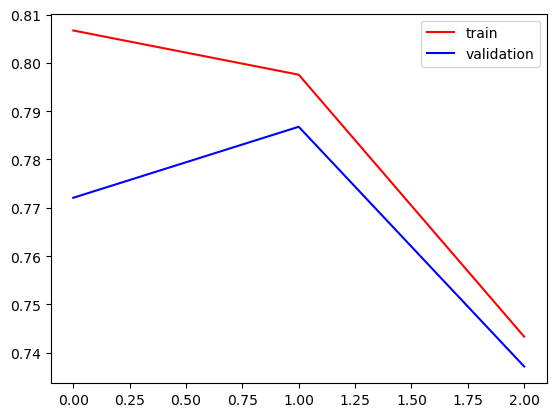

In [67]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

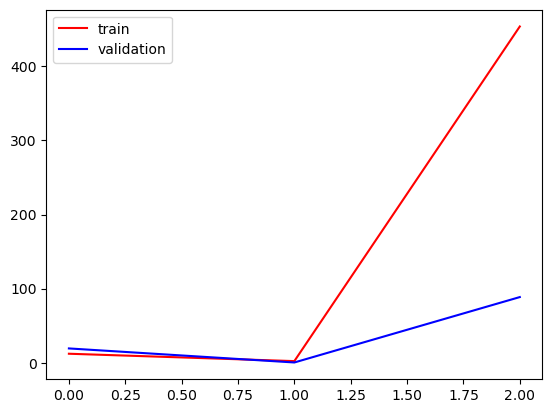

In [68]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## MobileNet Model

In [69]:
model_mobilenet = Sequential()

# Define the model architecture based on MobileNet
model_mobilenet.add(Conv2D(input_shape=(224, 224, 3), filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_mobilenet.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_mobilenet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_mobilenet.add(BatchNormalization())

model_mobilenet.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_mobilenet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_mobilenet.add(BatchNormalization())

model_mobilenet.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model_mobilenet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_mobilenet.add(BatchNormalization())

model_mobilenet.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model_mobilenet.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model_mobilenet.add(BatchNormalization())

model_mobilenet.add(Flatten())
model_mobilenet.add(Dense(units=128, activation="relu"))
model_mobilenet.add(Dense(units=64, activation="relu"))
model_mobilenet.add(Dense(units=4, activation="softmax"))

In [70]:
model_mobilenet.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 batch_normalization_6 (Bat  (None, 112, 112, 64)      256       
 chNormalization)                                                
                                                                 
 conv2d_14 (Conv2D)          (None, 112, 112, 128)     73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 56, 56, 128)      

In [72]:
model_mobilenet.compile(optimizer='adam',loss='categorical_crossentropy',metrics=metrics)

In [73]:
history = model_mobilenet.fit(train_dataset,epochs=3,validation_data=val_dataset,verbose=1)

Epoch 1/3
140/140 [==============================] - 894s 6s/step - loss: 0.4849 - accuracy: 0.8145 - top_k_accuracy: 0.9924 - val_loss: 7.2384 - val_accuracy: 0.2812 - val_top_k_accuracy: 0.5699
Epoch 2/3
140/140 [==============================] - 855s 6s/step - loss: 0.2721 - accuracy: 0.8886 - top_k_accuracy: 0.9975 - val_loss: 6.8674 - val_accuracy: 0.3107 - val_top_k_accuracy: 0.6985
Epoch 3/3
140/140 [==============================] - 870s 6s/step - loss: 0.2363 - accuracy: 0.9009 - top_k_accuracy: 0.9989 - val_loss: 0.1859 - val_accuracy: 0.9081 - val_top_k_accuracy: 1.0000


In [74]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_top_k_accuracy = model_mobilenet.evaluate(test_dataset)

# Print the final metrics
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Top-K Accuracy (K=2): {test_top_k_accuracy}')

17/17 [==============================] - 34s 2s/step - loss: 8476.4121 - accuracy: 0.4724 - top_k_accuracy: 1.0000
Test Loss: 8476.412109375
Test Accuracy: 0.47242647409439087
Test Top-K Accuracy (K=2): 1.0


In [75]:
from tensorflow.keras.models import save_model
model_path = 'model_mobilenet.h5'
# Save the model
save_model(model_mobilenet, model_path)

C:\Users\Dell\AppData\Local\Temp\ipykernel_10740\1020835365.py:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_mobilenet, model_path)


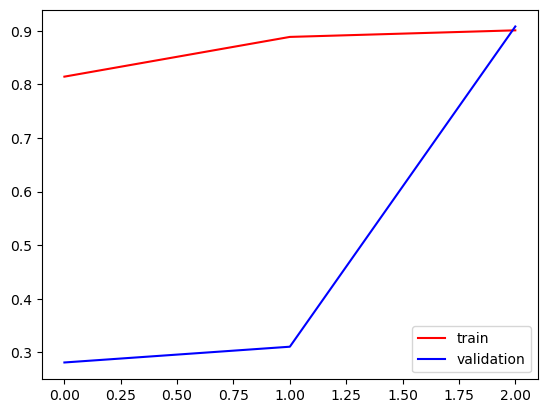

In [77]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

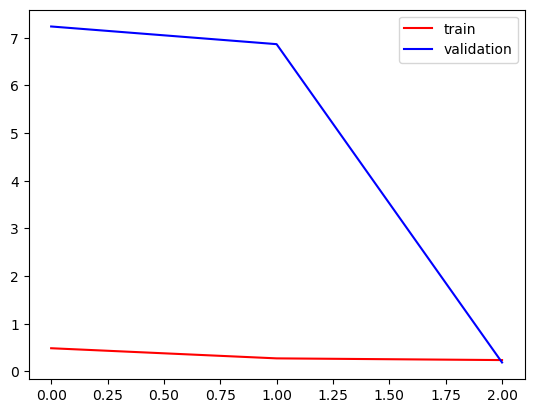

In [78]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

## EfficientNET

In [89]:
main_component = tf.keras.applications.efficientnet.EfficientNetB2(
                             include_top=False,
                             weights='imagenet',
                             input_shape=(224,224,3)
)

31790344/31790344 [==============================] - 7s 0us/step


In [90]:
EfficientNet_Model = tf.keras.Sequential([
         Input(shape=(224,224,3)),
         main_component,
         GlobalAveragePooling2D(),
     
       
         Dense(1024, activation='relu'),
         BatchNormalization(),
    
         Dense(128, activation='relu'),
         
         Dense(4, activation = 'softmax')
])

In [91]:
EfficientNet_Model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional  (None, 7, 7, 1408)        7768569   
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1408)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_24 (Dense)            (None, 1024)              1442816   
                                                                 
 batch_normalization_10 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 128)               131200    
                                                      

In [92]:
EfficientNet_Model.compile(loss=categorical_crossentropy,
                   optimizer = Adam(learning_rate=0.01),
                   metrics=metrics)

In [95]:
History = EfficientNet_Model.fit(train_dataset,validation_data=val_dataset,epochs=3,verbose=1)

Epoch 1/3
140/140 [==============================] - 692s 5s/step - loss: 0.4050 - accuracy: 0.7569 - top_k_accuracy: 0.9933 - val_loss: 788886.0000 - val_accuracy: 0.2445 - val_top_k_accuracy: 1.0000
Epoch 2/3
140/140 [==============================] - 813s 6s/step - loss: 0.3483 - accuracy: 0.8661 - top_k_accuracy: 0.9915 - val_loss: 2217.3020 - val_accuracy: 0.0000e+00 - val_top_k_accuracy: 0.8934
Epoch 3/3
140/140 [==============================] - 668s 5s/step - loss: 0.2747 - accuracy: 0.9089 - top_k_accuracy: 0.9940 - val_loss: 4.4036 - val_accuracy: 0.2224 - val_top_k_accuracy: 0.4908


In [96]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_top_k_accuracy = EfficientNet_Model.evaluate(test_dataset)

# Print the final metrics
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Top-K Accuracy (K=2): {test_top_k_accuracy}')

17/17 [==============================] - 22s 1s/step - loss: 12214.6250 - accuracy: 0.2224 - top_k_accuracy: 0.7555
Test Loss: 12214.625
Test Accuracy: 0.22242647409439087
Test Top-K Accuracy (K=2): 0.7555146813392639


In [ ]:
from tensorflow.keras.models import save_model
model_path = 'EfficientNet_Model.h5'
# Save the model
save_model(EfficientNet_Model, model_path)

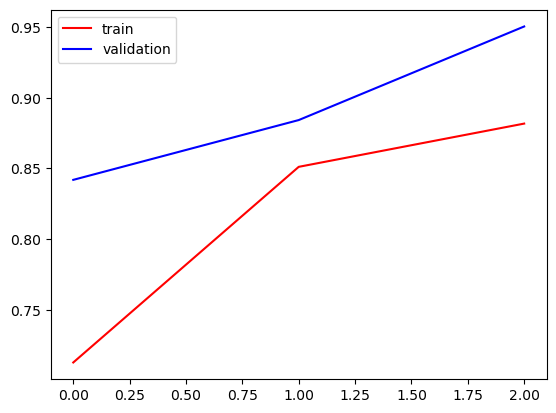

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

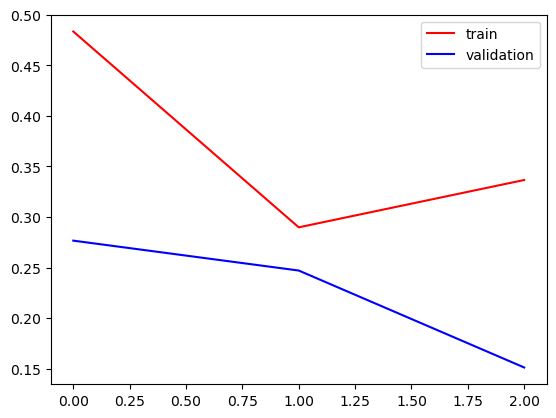

In [98]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [100]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 38.6/38.6 MB 4.6 MB/s eta 0:00:00


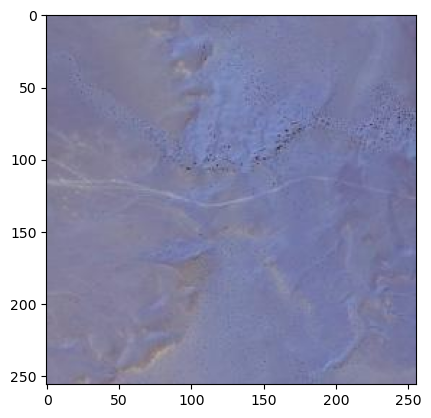

In [101]:
import cv2
test_img = cv2.imread(r'desert(92).jpg')
plt.imshow(test_img)

In [102]:
test_img = cv2.resize(test_img,(224,224))
test_input = test_img.reshape((1,224,224,3))

In [109]:
class_names = ["cloudy", "desert", "green_area", "water"]

In [110]:
result1 = model_VggNet.predict(test_input)
predicted_class_index = np.argmax(result1)
predicted_class = class_names[predicted_class_index]

print("Predicted class by VGGNet model:", predicted_class)

1/1 [==============================] - 1s 1s/step
Predicted class by VGGNet model: desert


In [111]:
result2 = model_resnet.predict(test_input)
predicted_class_index = np.argmax(result2)
predicted_class = class_names[predicted_class_index]

print("Predicted class by ResNet model:", predicted_class)

1/1 [==============================] - 7s 7s/step
Predicted class by ResNet model: desert


In [112]:
result3 = model_mobilenet.predict(test_input)
predicted_class_index = np.argmax(result3)
predicted_class = class_names[predicted_class_index]

print("Predicted class by MobileNet model:", predicted_class)

1/1 [==============================] - 0s 84ms/step
Predicted class by MobileNet model: desert


In [113]:
result4 = EfficientNet_Model.predict(test_input)
predicted_class_index = np.argmax(result4)
predicted_class = class_names[predicted_class_index]

print("Predicted class by EfficientNet model:", predicted_class)

1/1 [==============================] - 0s 168ms/step
Predicted class by EfficientNet model: desert


So we can see that all the models are correctly predicting the class of image

## Model Comparision

| Model | Test Loss | Test Accuracy |
|----------|----------|----------|
| VGGNet | 640.6592407226562 | 0.4889705777168274 |
| ResNet | 1455453.875 | 0.501838207244873 |
| MobileNet | 8476.412109375 | 0.47242647409439087 |
| EfficientNet | 12214.625 | 0.22242647409439087 |


#### Test Loss: 
Test loss measures the discrepancy between the actual and predicted values on the test dataset. Lower test loss values indicate better performance in terms of minimizing prediction errors. In this comparison:

* VGGNet achieves the lowest test loss among the models, indicating relatively better predictive accuracy on the test dataset.
* ResNet and MobileNet also have comparable test loss values, although higher than VGGNet.
* EfficientNet exhibits the highest test loss among the models, suggesting poorer predictive performance compared to others.


#### Test Accuracy: 
Test accuracy reflects the proportion of correctly predicted labels on the test dataset. Higher test accuracy values indicate better model performance in correctly classifying samples. In this comparison:

* ResNet achieves the highest test accuracy among the models, indicating better overall classification performance on the test dataset.
* VGGNet and MobileNet exhibit similar test accuracy values, although slightly lower than ResNet.
* EfficientNet demonstrates the lowest test accuracy among the models, indicating inferior classification performance compared to others.

## Conclusion
#### Overall, based on the test loss and test accuracy metrics, ResNet appears to outperform the other models, followed by VGGNet, MobileNet and EfficientNet